# Admixture data

In [2]:
import re, os, sys, math
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

from GenomicWindows import window
import GenomicIntervals


### Analysis dirs

In [3]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

### Local code in the scripts dir on the cluster

In [4]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

### Plotting setup

In [5]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

In [6]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

numpy.random.seed(7)

# Load meta data

In [7]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

# Laurtis original admixture data trained on autosomes

In [8]:
admix_segments = pandas.read_table(str(data_dir / 'laurits_data/Simon_All_mut.txt'), dtype={'chrom': str})
admix_segments.head(3)

,name,chrom,start,end,length,state,snps,region,population,country
0,S_Abkhasian-1,1,3104000,3113000,8000,2,10,WestEurasia,Abkhasian,Abkhazia
1,S_Abkhasian-1,1,4490000,4533000,42000,2,19,WestEurasia,Abkhasian,Abkhazia
2,S_Abkhasian-1,1,5320000,5347000,26000,2,13,WestEurasia,Abkhasian,Abkhazia


In [9]:
male_x_admix_segments = pandas.read_table(str(data_dir / 'laurits_data/RestofworldHMMHaploid_samePAR.txt'), dtype={'chrom': str})
male_x_admix_segments.head(3)

,name,chrom,start,end,length,state,snps,region,method,dataset,MeanProb,Altai,Denisova,Vindija,Denis,sex
0,S_Mixe-3,X,3117000,3193000,76000,2,"3118973,3119653,3127801,3164075,3165645,316895...",America,HMM,Sankararaman2016,0.784971,NaN,NaN,NaN,_SubAfr,F
1,S_Mixe-3,X,4258000,4277000,19000,2,"4260996,4261342,4266319",America,HMM,Sankararaman2016,0.603206,NaN,NaN,NaN,_SubAfr,F
2,S_Mixe-3,X,4657000,4681000,24000,2,"4662119,4667269,4677166,4678975",America,HMM,Sankararaman2016,0.710400,NaN,NaN,NaN,_SubAfr,F


In [10]:
admix_callability_windows = (pandas.read_table(str(data_dir / 'laurits_data/Callability_window_100000.txt'), 
                                      dtype={'chrom': str, 'start': int, 'end': int, 'round_pos': int})
                     .assign(start = lambda df:df.round_pos, 
                             end = lambda df:df.round_pos + 100000)
                    )

In [11]:
individuals_with_admix_on_X = set(admix_segments.loc[lambda df: df.chrom == 'X'].name.unique())

male_indiv = set([i for i, d in individuals.items() if d['Genetic sex assignment'] == 'XY'])

with_admix = sorted(male_indiv.difference(individuals_with_admix_on_X))
print("Out of {} male individuals, Laurits calls segments on X in only {}".format(len(male_indiv), len(with_admix)))
print('These male individuals do not have any admxiture called on X ({} out of {}):'.format(len(male_indiv)-len(with_admix), len(male_indiv)))
missing = [x for x in male_indiv if x not in with_admix]
print(", ".join(missing))

Out of 173 male individuals, Laurits calls segments on X in only 96
These male individuals do not have any admxiture called on X (77 out of 173):
S_Jordanian-1, S_Kyrgyz-1, S_Finnish-2, S_Tajik-2, S_Tuscan-2, S_Tujia-1, S_Yemenite_Jew-2, S_Mala-3, S_Bergamo-1, S_Turkish-1, S_Papuan-11, S_Iranian-1, S_Irula-1, S_Chane-1, S_Brahui-2, S_Maori-1, S_Thai-1, S_Bengali-1, S_Jordanian-2, S_Kusunda-1, S_Brahmin-2, S_Uygur-2, S_Xibo-1, S_Papuan-2, S_Burmese-2, S_Ami-1, S_Lezgin-2, S_North_Ossetian-2, S_Hazara-2, S_Igorot-2, S_Jordanian-3, S_Aleut-1, S_Greek-1, S_Atayal-1, S_Japanese-3, S_Tlingit-1, S_Madiga-1, S_Mala-2, S_Kapu-2, S_Sardinian-1, S_Papuan-4, S_Polish-1, S_Papuan-8, S_Hungarian-2, S_BedouinB-1, S_Tajik-1, S_Yi-1, S_Samaritan-1, S_Bulgarian-2, S_Hazara-1, S_Georgian-2, S_Czech-2, S_Palestinian-1, S_Estonian-2, S_Sindhi-1, S_She-2, S_Estonian-1, S_Zapotec-2, S_Kalash-1, S_North_Ossetian-1, S_Saami-2, S_Kusunda-2, S_Ami-2, S_Madiga-2, S_Papuan-10, S_Relli-1, S_Han-2, S_Abkhasian-1, S_

**NB:** Laurits' data only contain called segments, so individuals with no called segments on X (there are a few) will not be included

## MAKE SURE TO RESOLVE THIS!!!

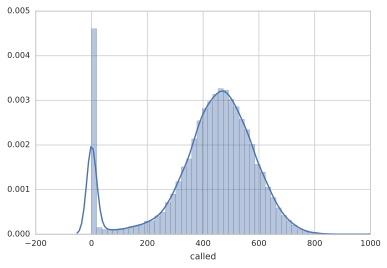

In [11]:
g = sns.distplot(admix_callability_windows.called)

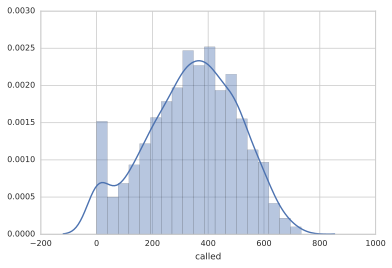

In [12]:
g = sns.distplot(admix_callability_windows.loc[lambda df: df.chrom == 'X', 'called'])

### By individual in 100kb windows

In [13]:
min_called_admix = 200

window_size = 100000
@window(size=window_size, fill={'nr_admix_tracts': 0, 'tot_admix_len': 0, 'admix_prop': 0})
def stats(df):
    return {'nr_admix_tracts': df.start.count(), 
            'tot_admix_len': sum(df.end-df.start), 
            'admix_prop': sum(df.end-df.start) / window_size}
                                   
cols = ['chrom', 'name', 'population', 'region']

df = (admix_segments.loc[lambda df: df.chrom == 'X']
                 .groupby(cols)
                 .apply(stats)
                 .reset_index(level=cols)
                )
admix_windows_chrX = df.merge(admix_callability_windows, on=['chrom', 'start', 'end'], how='left')
admix_windows_chrX.loc[lambda df: df.called < min_called_admix] = numpy.nan

df = (admix_segments.loc[lambda df: df.chrom == '7']
                 .groupby(cols)
                 .apply(stats)
                 .reset_index(level=cols)
                )
admix_windows_chr7 = df.merge(admix_callability_windows, on=['chrom', 'start', 'end'], how='left')
admix_windows_chr7.loc[lambda df: df.called < min_called_admix] = numpy.nan

admix_windows_chrX.to_hdf(results_dir / 'admix_windows_chrX.hdf', 'df', mode='w')
admix_windows_chr7.to_hdf(results_dir / 'admix_windows_chr7.hdf', 'df', mode='w')

/home/kmt/anaconda2/envs/simons/lib/python3.5/site-packages/pandas/core/generic.py:1299: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['chrom', 'name', 'population', 'region']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


Mb means:

In [14]:
@window(size=1000000)
def mb_means(df):
    return {'nr_admix_tracts': df.nr_admix_tracts.mean(), 
            'tot_admix_len': df.tot_admix_len.mean(), 
            'admix_prop': df.admix_prop.mean()}

cols = ['chrom', 'name', 'population', 'region']
admix_1Mb_windows_chrX = (admix_windows_chrX
                          .groupby(cols)
                          .apply(mb_means)
                          .reset_index(level=cols)
                          )
admix_1Mb_windows_chr7 = (admix_windows_chr7
                          .groupby(cols)
                          .apply(mb_means)
                          .reset_index(level=cols)
                          )

admix_1Mb_windows_chrX.to_hdf(results_dir / 'admix_1Mb_windows_chrX.hdf', 'df', mode='w')
admix_1Mb_windows_chr7.to_hdf(results_dir / 'admix_1Mb_windows_chr7.hdf', 'df', mode='w')

### Population means

In [15]:
cols = ['chrom', 'start', 'end', 'population', 'region']
admix_windows_by_pop_chrX = (admix_windows_chrX
                             .groupby(cols)
                             .aggregate(numpy.mean)
                             .reset_index(level=cols)
                            )
admix_windows_by_pop_chr7 = (admix_windows_chr7
                             .groupby(cols)
                             .aggregate(numpy.mean)
                             .reset_index(level=cols)
                            )
admix_windows_by_pop_chrX.to_hdf(results_dir / 'admix_windows_by_pop_chrX.hdf', 'df', mode='w')
admix_windows_by_pop_chr7.to_hdf(results_dir / 'admix_windows_by_pop_chr7.hdf', 'df', mode='w')

### Global admixture proportion

In [16]:
pandas.concat([admix_windows_chrX, admix_windows_chr7]).groupby('chrom').aggregate(numpy.mean)

,start,end,tot_admix_len,admix_prop,nr_admix_tracts,round_pos,called
chrom,,,,,,,
7,7.907154e+07,7.917154e+07,2976.280562,0.029763,0.077040,7.907154e+07,472.095167
X,7.270352e+07,7.280352e+07,1058.048701,0.010580,0.029331,7.270352e+07,402.759955


### Mean admixture proportion on chrX

In [17]:
admix_windows_chrX.groupby('region').aggregate(numpy.mean)

,start,end,tot_admix_len,admix_prop,nr_admix_tracts,round_pos,called
region,,,,,,,
America,7.504406e+07,7.514406e+07,1287.782971,0.012878,0.039501,7.504406e+07,402.766100
CentralAsiaSiberia,7.385375e+07,7.395375e+07,1272.048174,0.012720,0.035826,7.385375e+07,402.435107
EastAsia,7.342659e+07,7.352659e+07,1100.832806,0.011008,0.031098,7.342659e+07,402.769653
Oceania,7.469058e+07,7.479058e+07,1842.301582,0.018423,0.044415,7.469058e+07,402.543121
SouthAsia,7.257268e+07,7.267268e+07,1019.154907,0.010192,0.027411,7.257268e+07,402.810578
WestEurasia,7.099785e+07,7.109785e+07,705.300912,0.007053,0.020772,7.099785e+07,402.886020


In [18]:
admix_windows_chr7.groupby('region').aggregate(numpy.mean)

,start,end,tot_admix_len,admix_prop,nr_admix_tracts,round_pos,called
region,,,,,,,
America,7.911385e+07,7.921385e+07,3017.876547,0.030179,0.078482,7.911385e+07,471.983829
CentralAsiaSiberia,7.923946e+07,7.933946e+07,3427.504861,0.034275,0.086559,7.923946e+07,472.164393
EastAsia,7.937660e+07,7.947660e+07,3213.746740,0.032137,0.085548,7.937660e+07,472.206447
Oceania,7.971342e+07,7.981342e+07,4564.855806,0.045649,0.106501,7.971342e+07,472.345374
SouthAsia,7.921956e+07,7.931956e+07,2832.459699,0.028325,0.074229,7.921956e+07,472.140172
WestEurasia,7.851518e+07,7.861518e+07,2218.426398,0.022184,0.059802,7.851518e+07,471.925091


### Region admix means in windows

Density of adxture tracts along the genome

/home/kmt/anaconda2/envs/simons/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


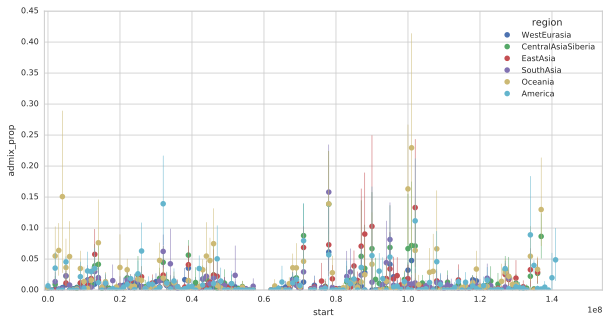

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
with sns.plotting_context('paper', font_scale=1, rc={"lines.linewidth": 0.5}): # paper, notebook, talk”, poster
    g = sns.tsplot(data=admix_1Mb_windows_chrX, time='start', value='admix_prop', 
           unit='name', condition='region', 
           err_style="ci_bars", 
           ci=[95], 
           interpolate=False, ax=ax)

### Make a dataframe suitable for plotting with the low pi regions

In [20]:
def region_admix_prop_means(df):
    df = df.copy()
    df.admix_prop = df.admix_prop.mean()
    return df

region_admix_prop_with_pops = (admix_windows_chrX[['region', 'population', 'start', 'end', 'admix_prop']]
                               .groupby(['region', 'population', 'start', 'end'])
                               .aggregate('mean')
                               .reset_index()
                               .groupby(['region', 'start', 'end'])
                               .apply(region_admix_prop_means)
                               .reset_index(drop=True)
                              )

pop_categories = pandas.read_hdf(str(results_dir / 'population_categories.store'), 'sr')

pop_codes = list()
pop_cats = list(pop_categories)
for pop in region_admix_prop_with_pops.population:
    if pop in pop_cats:
        pop_codes.append(pop_cats.index(pop))
    else:
        pop_codes.append(numpy.nan)

region_admix_prop_with_pops['pop_code'] = pop_codes

region_admix_prop_with_pops.to_hdf(results_dir / 'region_admix_prop_with_pops.hdf', 'df', mode='w')

# Laurtis admixture data trained on male x only

Laurits decodeed a few Africans by mistake, so I need to filter to get only the Africans:

In [12]:
non_african_indiv = [i for i, d in individuals.items() if d['Region'] != 'Africa']

In [13]:
min_post_prop_cutoff = 0.8

male_x_admix_segments = (pandas.read_table(str(data_dir / 'laurits_data/RestofworldHMMHaploid_samePAR.txt'), 
                                          dtype={'chrom': str})
                         .loc[lambda df: df.name.isin(non_african_indiv)]
                         .loc[lambda df: df.MeanProb >= min_post_prop_cutoff]
                        )

male_x_admix_segments.Altai.fillna('', inplace=True)
male_x_admix_segments.Denisova.fillna('', inplace=True)
male_x_admix_segments.Vindija.fillna('', inplace=True)

male_x_admix_segments['archaic_snps'] = [x[0] and len(x) or 0 for x in male_x_admix_segments.snps.str.split(',')]
male_x_admix_segments['altai_snps'] = [x[0] and len(x) or 0 for x in male_x_admix_segments.Altai.str.split(',')]
male_x_admix_segments['denisova_snps'] = [x[0] and len(x) or 0 for x in male_x_admix_segments.Denisova.str.split(',')]
male_x_admix_segments['vindija_snps'] = [x[0] and len(x) or 0 for x in male_x_admix_segments.Vindija.str.split(',')]

male_x_admix_segments.to_hdf(results_dir / 'male_x_admix_segments.hdf', 'df', format='table', mode='w')

print(len(male_x_admix_segments))
male_x_admix_segments.head()

3839


,name,chrom,start,end,length,state,snps,region,method,dataset,MeanProb,Altai,Denisova,Vindija,Denis,sex,archaic_snps,altai_snps,denisova_snps,vindija_snps
7,S_Mixe-3,X,10824000,10883000,59000,2,"10836412,10840217,10851082,10863089,10879896",America,HMM,Sankararaman2016,0.806746,,,,_SubAfr,F,5,0,0,0
15,S_Mixe-3,X,32184000,32328000,144000,2,"32189906,32190524,32210110,32219991,32229705,3...",America,HMM,Sankararaman2016,0.955586,"32219991,32229993,32237440,32238844,32245990,3...","32237440,32238844,32261577,32267117,32277122,3...","32219991,32229993,32237440,32238844,32245990,3...",_SubAfr,F,32,17,8,21
16,S_Mixe-3,X,32827000,32863000,36000,2,"32831155,32832426,32835686,32850514,32857822,3...",America,HMM,Sankararaman2016,0.831880,,,,_SubAfr,F,6,0,0,0
17,S_Mixe-3,X,33048000,33115000,67000,2,"33050583,33050839,33061285,33061223,33066189,3...",America,HMM,Sankararaman2016,0.951556,"33050583,33050839,33061285,33061223,33066189,3...",,"33050583,33050839,33061285,33061223,33066189,3...",_SubAfr,F,11,7,0,8
19,S_Mixe-3,X,34999000,35087000,88000,2,"35021668,35035411,35040599,35048337,35047918,3...",America,HMM,Sankararaman2016,0.825583,,,,_SubAfr,F,10,0,0,0


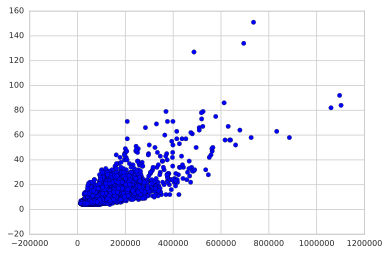

In [46]:
g = plt.scatter(male_x_admix_segments.length, male_x_admix_segments.archaic_snps)

In [48]:
male_x_admix_segments.loc[lambda df: (df.name == 'S_Papuan-10')].sort_values(by=['length'], ascending=False).head()

,name,chrom,start,end,length,state,snps,region,method,dataset,MeanProb,Altai,Denisova,Vindija,Denis,sex,archaic_snps,altai_snps,denisova_snps,vindija_snps
4675,S_Papuan-10,X,14642000,14953000,311000,2,"14647548,14650798,14653243,14657665,14665665,1...",Oceania,HMM,Sankararaman2016,0.973964,"14653243,14657665,14694174,14698027,14719404,1...",,"14647548,14653243,14657665,14665665,14694174,1...",_SubAfr,M,31,16,0,26
4666,S_Papuan-10,X,4231000,4515000,284000,2,"4234674,4234737,4236148,4255989,4261908,426150...",Oceania,HMM,Sankararaman2016,0.971534,"4234674,4236148,4359924,4377326,4379336,438917...","4234674,4236148,4262111,4264715,4293098,431456...","4234674,4236148,4359924,4377326,4379336,438917...",_SubAfr,M,66,10,18,11
4696,S_Papuan-10,X,100372000,100577000,205000,2,"100374226,100395569,100396158,100400872,100460...",Oceania,HMM,Sankararaman2016,0.924169,"100374226,100396158,100400872,100472783,100477...","100501305,100503284,100538339","100374226,100395569,100396158,100400872,100470...",_SubAfr,M,19,11,3,14
4668,S_Papuan-10,X,5762000,5928000,166000,2,"5771479,5782709,5788371,5791119,5795410,582825...",Oceania,HMM,Sankararaman2016,0.914829,,,,_SubAfr,M,17,0,0,0
4674,S_Papuan-10,X,13947000,14099000,152000,2,"13950724,13958152,13960603,13965821,13975537,1...",Oceania,HMM,Sankararaman2016,0.947692,"13950724,13965821,13975537,14006751,14007932,1...","14006751,14048509","13950724,13958152,13965821,13975537,13981174,1...",_SubAfr,M,29,14,2,12


## Callability windows

In [23]:
admix_callability_windows = (pandas.read_table(str(data_dir / 'laurits_data/Callability_window_100000.txt'), 
                                      dtype={'chrom': str, 'start': int, 'end': int, 'round_pos': int})
                    .assign(start = lambda df:df.round_pos, 
                             end = lambda df:df.round_pos + 100000)
                    )
admix_callability_windows.head()

,round_pos,chrom,called,end,start
0,0,1,0.0,100000,0
1,0,10,0.0,100000,0
2,0,11,0.0,100000,0
3,0,12,0.0,100000,0
4,0,13,0.0,100000,0


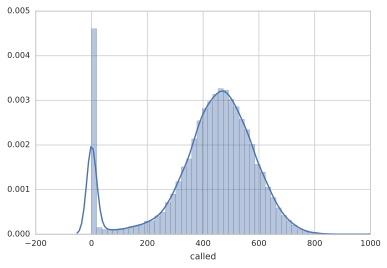

In [24]:
g = sns.distplot(admix_callability_windows.called)

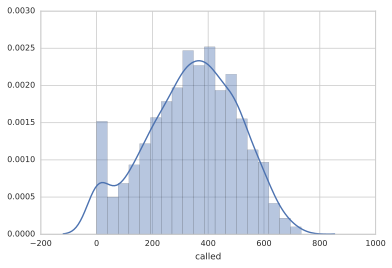

In [25]:
g = sns.distplot(admix_callability_windows.loc[lambda df: df.chrom == 'X', 'called'])

### By individual in 100kb windows

In [26]:
min_called_admix = 200

window_size = 100000
@window(size=window_size, fill={'nr_admix_tracts': 0, 'tot_admix_len': 0, 'admix_prop': 0,
                               'archaic_snps': 0, 'altai_snps': 0, 'denisova_snps': 0, 'vindija_snps': 0})
def stats(df):
    return {'nr_admix_tracts': df.start.count(), 
            'tot_admix_len': sum(df.end-df.start),
            'archaic_snps': df.archaic_snps.sum(),
            'altai_snps': df.altai_snps.sum(),
            'denisova_snps': df.denisova_snps.sum(),
            'vindija_snps': df.vindija_snps.sum(),
            'admix_prop': sum(df.end-df.start) / window_size}
                                   
df = (male_x_admix_segments.loc[lambda df: df.chrom == 'X']
                 .groupby(['chrom', 'name'])
                 .apply(stats)
                 .reset_index(level=['chrom', 'name'])
                )

male_x_admix_windows = df.merge(admix_callability_windows, on=['chrom', 'start', 'end'], how='left')

male_x_admix_windows.loc[lambda df: df.called < min_called_admix, 'admix_prop'] = numpy.nan
male_x_admix_windows.loc[lambda df: df.called < min_called_admix, 'archaic_snps'] = numpy.nan
male_x_admix_windows.loc[lambda df: df.called < min_called_admix, 'altai_snps'] = numpy.nan
male_x_admix_windows.loc[lambda df: df.called < min_called_admix, 'denisova_snps'] = numpy.nan
male_x_admix_windows.loc[lambda df: df.called < min_called_admix, 'vindija_snps'] = numpy.nan

male_x_admix_windows.head()

,chrom,name,start,end,altai_snps,tot_admix_len,admix_prop,nr_admix_tracts,vindija_snps,archaic_snps,denisova_snps,round_pos,called
0,X,B_Australian-3,0,100000,NaN,0,NaN,0,NaN,NaN,NaN,0,13.42
1,X,B_Australian-3,100000,200000,NaN,0,NaN,0,NaN,NaN,NaN,100000,50.69
2,X,B_Australian-3,200000,300000,NaN,0,NaN,0,NaN,NaN,NaN,200000,97.54
3,X,B_Australian-3,300000,400000,0.0,0,0.0,0,0.0,0.0,0.0,300000,267.62
4,X,B_Australian-3,400000,500000,0.0,0,0.0,0,0.0,0.0,0.0,400000,232.68


In [50]:
#male_x_admix_windows.loc[lambda df: (df.admix_prop == 1) & (df.archaic_snps == 0)]

,chrom,name,start,end,altai_snps,tot_admix_len,admix_prop,nr_admix_tracts,vindija_snps,archaic_snps,denisova_snps,round_pos,called


In [27]:
male_x_admix_windows.to_hdf(results_dir / 'male_x_admix_windows.hdf', 'df', format='table', mode='w')

Distribution of number of archaic SNPs in windows with such SNPs:

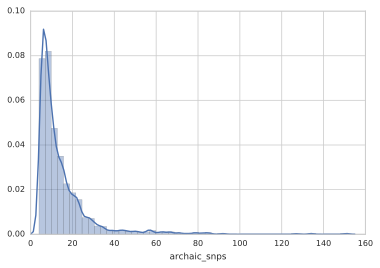

In [28]:
#male_x_admix_windows = pandas.read_hdf(results_dir / 'male_x_admix_windows.hdf')
g = sns.distplot(male_x_admix_windows.loc[lambda df: numpy.bitwise_and(~numpy.isnan(df.archaic_snps),
                                                                       df.archaic_snps != 0)].archaic_snps)

1Mb means:

In [30]:
window_size = 1000000
@window(size=window_size, fill={'nr_admix_tracts': 0, 'tot_admix_len': 0, 'admix_prop': 0,
                               'archaic_snps': 0, 'altai_snps': 0, 'denisova_snps': 0, 'vindija_snps': 0})
def mb_means(df):
    return {'nr_admix_tracts': df.nr_admix_tracts.mean(), 
            'tot_admix_len': df.tot_admix_len.mean(), 
            'archaic_snps': df.archaic_snps.sum(),
            'altai_snps': df.altai_snps.sum(),
            'denisova_snps': df.denisova_snps.sum(),
            'vindija_snps': df.vindija_snps.sum(),
            'admix_prop': df.admix_prop.mean()}

cols = ['chrom', 'name']
male_x_admix_windows_1Mb = (male_x_admix_windows
                          .groupby(cols)
                          .apply(mb_means)
                          .reset_index(level=cols)
                          )

male_x_admix_windows_1Mb.to_hdf(results_dir / 'male_x_admix_windows_1Mb.hdf', 'df', format='table', mode='w')

In [31]:
male_x_admix_windows_1Mb.head()

,chrom,name,start,end,altai_snps,tot_admix_len,admix_prop,nr_admix_tracts,vindija_snps,archaic_snps,denisova_snps
0,X,B_Australian-3,0,1000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,X,B_Australian-3,1000000,2000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,X,B_Australian-3,2000000,3000000,6.0,12000.0,0.133333,0.2,6.0,20.0,8.0
3,X,B_Australian-3,3000000,4000000,3.0,2400.0,0.030000,0.1,3.0,10.0,4.0
4,X,B_Australian-3,4000000,5000000,4.0,3100.0,0.031000,0.1,4.0,8.0,4.0


### Amount of admixture

In [33]:
def get_region(df):
    regions = list()
    for name in df.name:
        if name in individuals:
            regions.append(individuals[name]['Region'])
        else:
            regions.append(numpy.nan)
    return regions
    
male_x_admix_windows.assign(region = get_region).groupby(['region']).mean()

,start,end,altai_snps,tot_admix_len,admix_prop,nr_admix_tracts,vindija_snps,archaic_snps,denisova_snps,round_pos,called
region,,,,,,,,,,,
America,7.225856e+07,7.235856e+07,0.067726,1458.963076,0.016892,0.028920,0.081656,0.392227,0.020854,7.225856e+07,340.596699
CentralAsiaSiberia,7.280632e+07,7.290632e+07,0.064245,1451.977836,0.016247,0.027731,0.071954,0.386656,0.015226,7.280632e+07,341.664902
EastAsia,7.269037e+07,7.279037e+07,0.095715,1387.230765,0.016263,0.025934,0.112282,0.427434,0.021730,7.269037e+07,341.063136
Oceania,7.446706e+07,7.456706e+07,0.193757,1873.977175,0.022183,0.033915,0.229746,0.811082,0.130818,7.446706e+07,341.808296
SouthAsia,7.187063e+07,7.197063e+07,0.095859,1156.097382,0.013246,0.022546,0.123986,0.388648,0.036034,7.187063e+07,340.350928
WestEurasia,6.816347e+07,6.826347e+07,0.058641,1169.805372,0.013397,0.022479,0.074702,0.347482,0.018573,6.816347e+07,341.132033


## Archaic SNPs in windows along chromosome

For each window we need to know how many differences between male haplogypes are due to archiac snps. We want to be ale to filter them out to make sure it does not inflate estimated diffs in a way that makes unable to call sweeps in regions with admxiture.

Read all snp positions:

In [34]:
from collections import defaultdict

groups = male_x_admix_segments.groupby('name')

archaic_snps = defaultdict(set)
for indiv, group in groups:
    for tup in group.itertuples():
        one_based = map(int, tup.snps.split(','))
        zero_based = [x-1 for x in one_based]
        archaic_snps[indiv].update(zero_based)

In [35]:
import pyfaidx

file_index = dict()
for file_path in male_x_haploid_dir.glob('*.fa'):
    name = file_path.name.split('.')[0]
    file_index[name] = pyfaidx.Fasta(str(file_path), 
                                     strict_bounds=True, 
                                     one_based_attributes=False)

In [36]:
archaic_snps_by_indiv = None

male_indivs = list()
for indiv in male_x_admix_segments.name.unique():
    if individuals[indiv]['Genetic sex assignment'] == 'XY':
        male_indivs.append(indiv)

for indiv in male_indivs:    
    snps = archaic_snps[indiv]
    assert snps

#    indiv += '-A' ### Make table with indiv names without -A ......
    chrom = file_index[indiv + '-A']['X'][:].seq    
        
    bases = [chrom[pos] for pos in snps]
    df = pandas.DataFrame().from_records(zip(snps, bases), columns=['pos', 'base'])
    df[indiv] = True

    if archaic_snps_by_indiv is None:
        archaic_snps_by_indiv = df
    else:
        archaic_snps_by_indiv = archaic_snps_by_indiv.merge(df, on=['pos', 'base'], how='outer')
    
archaic_snps_by_indiv = archaic_snps_by_indiv.fillna(False)

In [37]:
archaic_snps_by_indiv.head()

,pos,base,S_Brahui-2,S_Finnish-3,S_Karitiana-1,S_Burusho-1,S_She-2,S_Armenian-2,S_Tu-1,S_Chane-1,...,S_Georgian-1,B_Sardinian-3,S_Han-2,S_Papuan-4,S_Yadava-1,S_Hazara-2,S_French-1,S_Greek-2,S_Iranian-1,S_Finnish-2
0,49552901,G,True,False,False,False,False,False,False,True,...,False,True,False,False,False,False,False,False,True,False
1,56271366,C,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,55083017,C,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,54948372,G,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,40231463,A,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Make sure there are at most one one ref and one alternative base for each position:

In [38]:
archaic_snps_by_indiv.loc[lambda df: df.base != 'N'].groupby(['pos'])['base'].count().unique()

array([1, 2])

Add all snps called in one individual to all indivisuals:

In [39]:
all_pos = archaic_snps_by_indiv.pos
all_bases = archaic_snps_by_indiv.base

archaic_snps_by_indiv.set_index(['pos', 'base'], inplace=True)

for indiv in male_indivs: 
    chrom = file_index[indiv + '-A']['X'][:].seq

    for pos, base in zip(all_pos, all_bases):
        if base != 'N' and chrom[pos] == base:
            archaic_snps_by_indiv.loc[(pos, base), indiv] = True

archaic_snps_by_indiv.reset_index(inplace=True)

In [40]:
for indiv in male_indivs:
    print(len(archaic_snps[indiv]), archaic_snps_by_indiv.loc[archaic_snps_by_indiv[indiv]].pos.size)

113 648
75 588
80 628
90 637
56 572
80 611
81 635
87 630
87 615
206 772
62 565
93 654
90 622
83 600
34 551
64 601
306 875
136 642
90 640
206 750
101 618
101 646
221 796
147 693
79 639
233 744
67 599
84 581
217 752
209 747
150 681
77 610
129 674
78 607
13 553
80 624
116 617
231 784
135 621
125 635
218 764
114 636
72 616
117 617
151 690
215 743
119 658
244 791
52 590
193 722
275 840
50 580
70 586
251 698
60 649
222 798
107 628
96 634
98 621
280 818
133 667
64 603
33 570
65 598
504 831
138 659
88 652
144 674
334 823
16 519
144 682
117 669
126 650
111 650
34 527
108 650
53 555
50 578
118 634
134 670
72 578
323 873
157 698
221 748
56 560
45 590
52 564
160 703
96 611
32 563
63 564
84 631
109 687
57 570
65 600
50 605
123 658
85 634
146 676
71 625
55 603
152 643
86 632
69 625
30 575
136 686
100 626
167 696
65 592
121 647
89 635
60 572
121 612
120 693
52 586
104 601
62 620
64 595
175 714
67 595
60 615
27 532
73 599
133 671
45 578
96 646
72 642
73 651
89 637
77 622
64 612
68 578
27 542
35 542
79

Compute the number of archaic SNPs in windows:

In [41]:
def archaic_snp_counts_in_windows(binsize):

#     indivs = male_x_admix_segments.name.unique()

    chrom_size = chromosome_lengths['X']
    cuts = list(range(0, chrom_size+1, binsize))

    pair_list = list()
    for indiv_1 in male_indivs:
        for indiv_2 in male_indivs:
            if indiv_1 == indiv_2:
                continue

#             snp_set1 = archaic_snps[indiv_1]
#             snp_set2 = archaic_snps[indiv_2]
            snp_set1 = set(archaic_snps_by_indiv.loc[archaic_snps_by_indiv[indiv_1]].pos)
            snp_set2 = set(archaic_snps_by_indiv.loc[archaic_snps_by_indiv[indiv_2]].pos)
            
            archaic_het_sites = sorted(snp_set1.symmetric_difference(snp_set2))
            
            bin_starts = pandas.cut(archaic_het_sites, bins=cuts, labels=cuts[:-1], right=False)
            df = DataFrame({'indiv_1': indiv_1, 
                            'indiv_2': indiv_2, 
                            'start': bin_starts, 
                            'archaic_hets': archaic_het_sites})
            df = df.groupby(['indiv_1', 'indiv_2', 'start']).count().reset_index()
            pair_list.append(df)

    return pandas.concat(pair_list)

In [42]:
archaic_snp_counts = archaic_snp_counts_in_windows(100000)
archaic_snp_counts.to_hdf(results_dir / 'archaic_snp_counts.hdf', 'df', format='table', mode='w')
archaic_snp_counts.head()

,indiv_1,indiv_2,start,archaic_hets
0,S_Brahui-2,S_Finnish-3,0,NaN
1,S_Brahui-2,S_Finnish-3,100000,NaN
2,S_Brahui-2,S_Finnish-3,200000,NaN
3,S_Brahui-2,S_Finnish-3,300000,NaN
4,S_Brahui-2,S_Finnish-3,400000,NaN


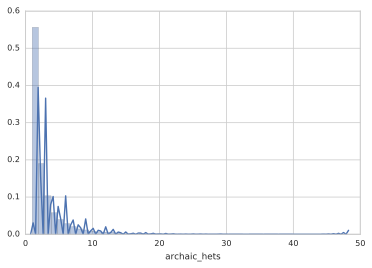

In [43]:
g = sns.distplot(archaic_snp_counts.archaic_hets.loc[archaic_snp_counts.archaic_hets > 0])

In [44]:
archaic_snp_counts_1Mb = archaic_snp_counts_in_windows(1000000)
archaic_snp_counts_1Mb.to_hdf(results_dir / 'archaic_snp_counts_1Mb.hdf', 'df', format='table', mode='w')
archaic_snp_counts_1Mb.head()

,indiv_1,indiv_2,start,archaic_hets
0,S_Brahui-2,S_Finnish-3,0,NaN
1,S_Brahui-2,S_Finnish-3,1000000,NaN
2,S_Brahui-2,S_Finnish-3,2000000,NaN
3,S_Brahui-2,S_Finnish-3,3000000,NaN
4,S_Brahui-2,S_Finnish-3,4000000,1.0


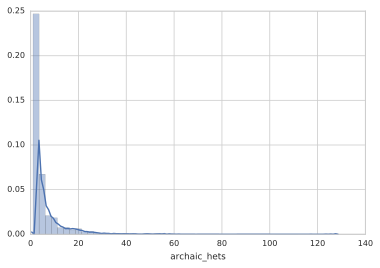

In [45]:
g = sns.distplot(archaic_snp_counts_1Mb.archaic_hets.loc[archaic_snp_counts_1Mb.archaic_hets > 0])